In [ ]:
!pip install tb

In [ ]:
!pip install attrdict

In [ ]:
!pip install d3rlpy

In [3]:
import os
import re

import torch
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
import random
import torchvision.utils as vutils
import argparse
import math
import cv2
from matplotlib import pyplot as plt

from torchsummary import summary

from abc import abstractmethod

# Set random seed for reproducibility
seed = 1141
# seed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", seed)
random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:8" if (torch.cuda.is_available()) else "cpu")

Random Seed:  1141


In [31]:
train_ds = EdgesDataset(config=config)

dataloader = DataLoader(train_ds, config.parameters.dreamer.batch_size, shuffle=False)

In [41]:
train_ds[0]

(tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[1., 0., 1.,  ..., 0., 0., 0.],
          [1., 1., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 1.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 1., 1., 1.]],
 
         [[0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 1.,  ..., 1., 1., 1.],
       

In [2]:
from encoder import Encoder

In [3]:
model = Encoder(config)

In [6]:
model.to('cuda')

Encoder(
  (_convs): Sequential(
    (0): Conv2dSame(2, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2dSame(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2dSame(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2dSame(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
  )
)

In [2]:
from decoder import Decoder

In [3]:
model = Decoder(config)

In [4]:
model.to('cuda')

Decoder(
  (_conv_transes): Sequential(
    (0): ConvTranspose2dSame(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2dSame(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2dSame(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): ConvTranspose2dSame(8, 2, kernel_size=(3, 3), stride=(2, 2))
    (10): Sigmoid()
  )
)

In [1]:
from vae import EdgeEntropyVAE

In [3]:
model = EdgeEntropyVAE(config, 0.5)

In [4]:
model

EdgeEntropyVAE(
  (encoder): Encoder(
    (_convs): Sequential(
      (0): Conv2dSame(2, 8, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2dSame(8, 16, kernel_size=(3, 3), stride=(2, 2))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Conv2dSame(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01)
      (9): Conv2dSame(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.01)
    )
  )
  (decoder): Decoder(
    (_conv_transes): Sequential(
      (0): ConvTranspose2dSame(64, 32, kernel_size=(3, 3), stride=(2, 2))
      (

In [10]:
model.reparameterize(torch.Tensor([0]), torch.Tensor([2]))

tensor([-0.3455])

In [15]:
torch.stack([torch.Tensor([[[0,1],[0,1]]]),torch.Tensor([[[1,1],[1,1]]])]).shape

torch.Size([2, 1, 2, 2])

In [54]:
import re
import cv2

def extract_metadata(fpath):
    
    with open(fpath, 'r') as file:
        info = file.read().rstrip()
        
    info_splited = info.split('_')
    
    timestep = int(info_splited[0])
    reward = int(info_splited[1])
    player_x = int(info_splited[2])
    player_y = int(info_splited[3])
    
    
    movements = info_splited[4].split(';')[:-1]
    
    walk_distance = jump_height = jump_true = 0
    
    for i in range(len(movements)):
        
        movement_list = [int(x) for x in list(movements[i])]
        
        if movement_list[0] == 1:
            walk_distance -= 1
            
        if movement_list[1] == 1:
            walk_distance += 1
        
        if movement_list[2] == 1:
            jump_true = 1
        
        # Если jumpt_true == 0, то не делаем ничего
        if (movement_list[3] == 0) and (jump_true == 1):
            jump_height += 1
        elif (movement_list[3] == 1) and (jump_true == 1):
            jump_height += 1
            jump_true = 0
    
    return timestep, reward, player_x, player_y, walk_distance, jump_height

def load_img(seed, timestep, config):
    
    image_path_1 = config.parameters.edges_dataset.data_root + f'/screenshots0000_{seed}/{timestep}.png'
    image_path_2 = re.sub(r'/screenshots/', r'/screenshots_add/', image_path_1)

    metadata_path = image_path_2[:-3] + 'txt'

    timestep, reward, player_x, player_y, walk_distance, jump_height = extract_metadata(metadata_path)

    if timestep < 7668:
        timestep_next = timestep + 6
        terminal = False
    else:
        terminal = True

    # do your magic here
    # флаг 0 = читаем черно-белое изображение
    img1 = cv2.imread(image_path_1, 0)
    img2 = cv2.imread(image_path_2, 0)

    img_full1 = transform_img(img1, dim=[self.config.image_size, self.config.image_size], zero_screenshot=self.zero_screenshot, aperture_size=self.config.aperture_size)
    img_full2 = transform_img(img2, dim=[self.config.image_size, self.config.image_size], zero_screenshot=self.zero_screenshot, aperture_size=self.config.aperture_size)

    img_part1 = transform_img(img1, dim=[self.config.image_size, self.config.image_size], zero_screenshot=self.zero_screenshot_part, part_size=self.config.part_size, player_x=player_x, player_y=player_y, aperture_size=self.config.aperture_size)
    img_part2 = transform_img(img2, dim=[self.config.image_size, self.config.image_size], zero_screenshot=self.zero_screenshot_part, part_size=self.config.part_size, player_x=player_x, player_y=player_y, aperture_size=self.config.aperture_size)

    sample_full = cv2.merge([img_full1, img_full2])
    sample_part = cv2.merge([img_part1, img_part2])
    
    return transforms.ToTensor()(sample_full), transforms.ToTensor()(sample_part), timestep, (player_x, player_y), (walk_distance, jump_height), reward, terminal

In [55]:
load_img(359803652, 12, config)

NameError: name 'transform_img' is not defined

In [3]:
train_ds = EdgesDataset(config=config)

dataloader = DataLoader(train_ds, config.parameters.dreamer.batch_size, shuffle=False)

In [4]:
seeds = get_seed_list(config.parameters.edges_dataset.data_root)

In [6]:
observations, actions, rewards, terminals = train_ds.load_episodes(seeds)

In [7]:
print(observations.shape, actions.shape, rewards.shape, terminals.shape)

(12770, 4, 64, 64) (12770, 2) (12770,) (12770,)


In [8]:
from d3rlpy.dataset import MDPDataset

dataset = MDPDataset(observations, actions, rewards, terminals, discrete_action=False)

In [16]:
dataset.dump('MDPdataset_SMF_' + datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

In [13]:
encoder = Encoder(config).to(device)

In [15]:
observation = buffer.sample(10,10)['observation']
torch.cat([encoder(observation[:,:,0,:,:]),encoder(observation[:,:,1,:,:]),encoder(observation[:,:,2,:,:]),encoder(observation[:,:,3,:,:])],-1)

tensor([[[ 2.3416e-01,  6.0045e-01,  1.3020e+00,  ...,  1.1233e-01,
           1.1233e-01, -8.3058e-04],
         [ 3.3554e-01,  9.1756e-01,  6.0683e-01,  ..., -5.1583e-04,
          -5.1583e-04,  1.5307e-01],
         [-1.5669e-03,  1.1114e+00,  5.8742e-01,  ...,  1.2243e+00,
           2.1191e-01,  2.8043e+00],
         ...,
         [-5.0152e-03,  1.6649e+00,  5.2799e-01,  ..., -6.6693e-03,
          -6.6693e-03, -5.2427e-03],
         [ 3.0595e-01,  1.8360e+00, -1.6966e-03,  ...,  1.9619e+00,
           1.6654e+00,  1.0970e+00],
         [-7.8754e-03,  1.2732e+00, -4.6416e-03,  ..., -2.4606e-02,
          -4.2104e-04, -3.7070e-03]],

        [[ 1.9091e+00,  1.2435e-01,  2.9624e+00,  ...,  1.3341e+00,
          -1.0054e-03,  4.9796e-01],
         [ 1.9683e+00,  8.7909e-01,  4.6802e-01,  ...,  2.9038e+00,
           4.3718e-01,  1.3804e+00],
         [ 1.4281e-01,  7.9280e-01,  2.2420e-01,  ...,  1.7712e+00,
           3.2704e+00,  1.3540e+00],
         ...,
         [-3.9153e-03,  3

In [21]:
encoder(buffer.sample(10,10)['observation'][:,:,3,:,:]).shape

torch.Size([10, 10, 1024])

In [1]:
config_file='config.yml'

import importlib

from dataset import EdgesDataset, get_seed_list
from utils import load_config
from torch.utils.data import DataLoader
import torch
import numpy as np

from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

config = load_config(config_file)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from d3rlpy.dataset import MDPDataset

dataset = MDPDataset.load('MDPdataset_SMF_2023-03-24_13-47-05')

In [3]:
observation_shape = dataset.get_observation_shape()
action_size =  dataset.get_action_size()

In [4]:
from buffer import ReplayBuffer

In [5]:
buffer = ReplayBuffer(observation_shape, action_size, config)

In [6]:
for episode in dataset.episodes:
    for transition in episode.transitions:
        buffer.add(transition.observation, transition.action, transition.reward, transition.next_observation, transition.terminal)

In [7]:
buffer.buffer_index

12770

In [8]:
import encoder
importlib.reload(encoder)
from encoder import Encoder

In [9]:
import decoder
importlib.reload(decoder)
from decoder import Decoder

In [10]:
import dreamer
importlib.reload(dreamer)
from dreamer import Dreamer

In [11]:
log_dir = (
        "runs/"
        + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        + "_"
        + config.operation.log_dir
    )
writer = SummaryWriter(log_dir)
device = config.operation.device
obs_shape = dataset.get_observation_shape()
discrete_action_bool = False 
action_size = dataset.get_action_size()

agent = Dreamer(
            obs_shape, discrete_action_bool, action_size, writer, device, config, verbose=False
        )

In [ ]:
agent.train_offline(buffer)

0.9593192934989929 1.1584423780441284
0.9506423473358154 1.1470787525177002
0.9413546323776245 1.1317545175552368
0.930801510810852 1.1121114492416382
0.9185632467269897 1.0973268747329712
0.9068682789802551 1.0736037492752075
0.8971750140190125 1.056428074836731
0.8859479427337646 1.042986273765564
0.8753405809402466 1.0227388143539429
0.8631572127342224 1.0026651620864868
0.8523587584495544 0.9861108660697937
0.8412675857543945 0.969808042049408
0.8308231234550476 0.9565055966377258
0.8210208415985107 0.9444640278816223
0.8111215829849243 0.9302526712417603
0.8022735118865967 0.9212366938591003
0.7928725481033325 0.9078409075737
0.7839319109916687 0.8978723287582397
0.7755494117736816 0.8869466781616211
0.7675520777702332 0.8762801885604858
0.7606133222579956 0.8671534657478333
0.7521322965621948 0.857887327671051
0.746127724647522 0.8497857451438904
0.7399208545684814 0.8405478000640869
0.7334149479866028 0.8328677415847778
0.7285389304161072 0.8253626823425293
0.7239091992378235 0.

0.4232521653175354 0.43273892998695374
0.39826399087905884 0.42590194940567017
0.41241157054901123 0.428911417722702
0.394747257232666 0.4303077459335327
0.40566083788871765 0.4265919327735901
0.401250958442688 0.4276871383190155
0.411043643951416 0.4257533848285675
0.38478371500968933 0.42579978704452515
0.41154196858406067 0.42695313692092896
0.4054817259311676 0.4228014349937439
0.4066082239151001 0.4269966185092926
0.40099096298217773 0.42095503211021423
0.40769097208976746 0.42680731415748596
0.3952025771141052 0.4169690012931824
0.38846874237060547 0.42366933822631836
0.4050305187702179 0.41607666015625
0.398343563079834 0.41718801856040955
0.39665383100509644 0.4205855429172516
0.39203575253486633 0.41597241163253784
0.4021557867527008 0.4153154492378235
0.39172855019569397 0.41172248125076294
0.386653870344162 0.41444510221481323
0.39016440510749817 0.41255608201026917
0.38587525486946106 0.4102134704589844
0.40735286474227905 0.41040971875190735
0.3935340344905853 0.4076961278

0.3269382119178772 0.29664671421051025
0.3144979178905487 0.28613364696502686
0.3250284790992737 0.294282466173172
0.33120959997177124 0.2926742434501648
0.3522515892982483 0.2924838960170746
0.29774269461631775 0.2797355055809021
0.36717689037323 0.2972394824028015
0.33825814723968506 0.2889274060726166
0.31116268038749695 0.2879382371902466
0.3546198010444641 0.289543479681015
0.3373011350631714 0.2959000766277313
0.3543401062488556 0.29437318444252014
0.34616634249687195 0.2900030016899109
0.3328081965446472 0.28968629240989685
0.308128297328949 0.2931310832500458
0.3078218400478363 0.2864389419555664
0.3640042841434479 0.29556113481521606
0.3259294331073761 0.2888964116573334
0.34497687220573425 0.29311707615852356
0.31068721413612366 0.27939552068710327
0.33975473046302795 0.28952863812446594
0.3303363025188446 0.2807680666446686
0.30569279193878174 0.2822900414466858
0.3238760232925415 0.28356993198394775
0.32264384627342224 0.2855983376502991
0.3074208199977875 0.279773801565170

0.3245905637741089 0.22621598839759827
0.26324018836021423 0.2315824180841446
0.27104851603507996 0.22678223252296448
0.28974324464797974 0.2300722450017929
0.2993181049823761 0.22697511315345764
0.29797667264938354 0.23147383332252502
0.3164023458957672 0.22584116458892822
0.34854158759117126 0.23874986171722412
0.3178388178348541 0.23918573558330536
0.31473666429519653 0.22928383946418762
0.3014105260372162 0.21897311508655548
0.32804349064826965 0.23006708920001984
0.31762832403182983 0.23367582261562347
0.30579522252082825 0.22605326771736145
0.31622520089149475 0.22836804389953613
0.2963198125362396 0.21937677264213562
0.3024780750274658 0.23194555938243866
0.30885303020477295 0.21962283551692963
0.28625792264938354 0.2288861870765686
0.30010801553726196 0.2303939312696457
0.3321201503276825 0.23925475776195526
0.28872278332710266 0.2324722558259964
0.29248639941215515 0.2220320850610733
0.30420541763305664 0.23474371433258057
0.3018178939819336 0.23501554131507874
0.3141050636768

0.30725282430648804 0.21560420095920563
0.25506919622421265 0.21331191062927246
0.24562449753284454 0.20134910941123962
0.26674342155456543 0.2067459374666214
0.3083694279193878 0.21124230325222015
0.33084261417388916 0.21807046234607697
0.2844497263431549 0.20105190575122833
0.30716902017593384 0.21067963540554047
0.30874910950660706 0.21640658378601074
0.30979377031326294 0.2191796600818634
0.2849390506744385 0.21001365780830383
0.32418084144592285 0.21222861111164093
0.28782618045806885 0.2075343132019043
0.27282553911209106 0.2174323946237564
0.3152811825275421 0.20850741863250732
0.3042440414428711 0.21127444505691528
0.3011404573917389 0.21374240517616272
0.29755687713623047 0.20111986994743347
0.2839563190937042 0.20458656549453735
0.29898181557655334 0.2088005393743515
0.2849094569683075 0.21360595524311066
0.3115871548652649 0.21127422153949738
0.2768186032772064 0.20974953472614288
0.3246460556983948 0.22601890563964844
0.28031694889068604 0.21525566279888153
0.30759316682815

0.28774479031562805 0.1939292848110199
0.2927228510379791 0.20320606231689453
0.30836865305900574 0.20679804682731628
0.30442678928375244 0.2155035436153412
0.2416917085647583 0.20833367109298706
0.296037882566452 0.1984410434961319
0.2656952738761902 0.21026095747947693
0.2750099003314972 0.21306179463863373
0.2726856470108032 0.19482718408107758
0.254980206489563 0.19242975115776062
0.289193719625473 0.19854062795639038
0.2926078140735626 0.20318342745304108
0.27101585268974304 0.20047283172607422
0.27284035086631775 0.2013055980205536
0.29366040229797363 0.192604199051857
0.2715904116630554 0.19525761902332306
0.26865649223327637 0.21216705441474915
0.29214122891426086 0.1959649622440338
0.29717734456062317 0.2084810584783554
0.25539353489875793 0.18821409344673157
0.25099581480026245 0.1897183507680893
0.2902238070964813 0.21055860817432404
0.3147115111351013 0.2107371985912323
0.29331591725349426 0.19281348586082458
0.28141099214553833 0.20527136325836182
0.26838064193725586 0.205

0.27418723702430725 0.1933598667383194
0.29861974716186523 0.1938386857509613
0.29382196068763733 0.19728593528270721
0.24047429859638214 0.1804410070180893
0.2884664535522461 0.2021642029285431
0.30234619975090027 0.20094360411167145
0.300611674785614 0.2000916302204132
0.2696705162525177 0.1856594830751419
0.32748356461524963 0.21084050834178925
0.2911568284034729 0.20134489238262177
0.26926857233047485 0.19036352634429932
0.3055051565170288 0.21538151800632477
0.2963423430919647 0.21018405258655548
0.2576236128807068 0.20185060799121857
0.2925300896167755 0.19357579946517944
0.2741899788379669 0.1876835972070694
0.28616034984588623 0.2030893713235855
0.2746657133102417 0.1995190680027008
0.2794452905654907 0.18997323513031006
0.30183130502700806 0.20852060616016388
0.28018271923065186 0.20978392660617828
0.277107834815979 0.1888660043478012
0.27453526854515076 0.19902779161930084
0.26472383737564087 0.18473657965660095
0.2629127502441406 0.1894593983888626
0.3009844422340393 0.19384

0.28558599948883057 0.18732352554798126
0.260409414768219 0.17841042578220367
0.29163509607315063 0.19439572095870972
0.3167351186275482 0.20671811699867249
0.24656976759433746 0.19791869819164276
0.273827463388443 0.2036961317062378
0.3102113604545593 0.19533300399780273
0.28110918402671814 0.18912480771541595
0.3249148726463318 0.19943539798259735
0.2775072157382965 0.19682027399539948
0.2854030430316925 0.19493988156318665
0.31392794847488403 0.2039056122303009
0.2670496106147766 0.18993590772151947
0.30089426040649414 0.20789536833763123
0.27278032898902893 0.19911205768585205
0.275949090719223 0.1879938244819641
0.30842241644859314 0.19326624274253845
0.27465909719467163 0.19610746204853058
0.27376753091812134 0.18557633459568024
0.2768392264842987 0.19192998111248016
0.2744438052177429 0.1938469260931015
0.28887346386909485 0.19365276396274567
0.28906330466270447 0.19796183705329895
0.2986096143722534 0.19356489181518555
0.2908739149570465 0.18870742619037628
0.30860573053359985 

0.2972916066646576 0.19011954963207245
0.25172510743141174 0.17527751624584198
0.29464253783226013 0.17963862419128418
0.2937036156654358 0.19269336760044098
0.30026039481163025 0.18766848742961884
0.2595631182193756 0.1825983077287674
0.2918265759944916 0.1921503245830536
0.29934820532798767 0.17718666791915894
0.28590551018714905 0.18155387043952942
0.2856868803501129 0.1835549771785736
0.2986126244068146 0.1791892647743225
0.3216976225376129 0.19740475714206696
0.30034711956977844 0.19120880961418152
0.2792326509952545 0.18440745770931244
0.27385225892066956 0.19247345626354218
0.2929169237613678 0.18729957938194275
0.3189282715320587 0.19315102696418762
0.31344589591026306 0.1976301670074463
0.2750844955444336 0.18719162046909332
0.2501909136772156 0.17365415394306183
0.30470210313796997 0.2036755532026291
0.28579407930374146 0.18571758270263672
0.24720531702041626 0.1781815141439438
0.2638697922229767 0.18306422233581543
0.288549542427063 0.19306816160678864
0.2766970694065094 0.1

0.2717304229736328 0.17302347719669342
0.26228925585746765 0.1780814230442047
0.28303349018096924 0.18923825025558472
0.31063392758369446 0.19397905468940735
0.3143080770969391 0.18305766582489014
0.2639511823654175 0.17428705096244812
0.2703433930873871 0.18078356981277466
0.29930371046066284 0.1749723106622696
0.2847687005996704 0.18426291644573212
0.26987019181251526 0.19117790460586548
0.30663880705833435 0.17798270285129547
0.27393966913223267 0.17000794410705566
0.28672856092453003 0.17866210639476776
0.27269524335861206 0.18314287066459656
0.29278436303138733 0.19314205646514893
0.30159494280815125 0.19237232208251953
0.3205447793006897 0.19004523754119873
0.2944449782371521 0.1911366879940033
0.28483524918556213 0.1825316995382309
0.30456414818763733 0.18865275382995605
0.3013751804828644 0.19737964868545532
0.26749661564826965 0.17991703748703003
0.270575612783432 0.17634575068950653
0.28429558873176575 0.1891508251428604
0.2850629687309265 0.18819394707679749
0.24943664669990

0.25163769721984863 0.1731855422258377
0.2934904098510742 0.1624164581298828
0.29548099637031555 0.17728452384471893
0.30229809880256653 0.18429172039031982
0.268262654542923 0.16945010423660278
0.25134098529815674 0.17022576928138733
0.3581642210483551 0.1964576095342636
0.2876065969467163 0.1808108538389206
0.26003891229629517 0.17796264588832855
0.3054201602935791 0.17518988251686096
0.29583126306533813 0.18319711089134216
0.3046426773071289 0.17128102481365204
0.2995619475841522 0.18023861944675446
0.2506255507469177 0.16393640637397766
0.27459266781806946 0.16604846715927124
0.28640249371528625 0.17186221480369568
0.2850906550884247 0.1772584468126297
0.28543412685394287 0.17419345676898956
0.2988167107105255 0.1751129925251007
0.3144627809524536 0.18488705158233643
0.2899029552936554 0.17815788090229034
0.29939642548561096 0.16771560907363892
0.29228705167770386 0.18240489065647125
0.28510573506355286 0.17608803510665894
0.25874051451683044 0.17369148135185242
0.3076588809490204 

0.2925639748573303 0.17525923252105713
0.24852533638477325 0.1672292798757553
0.2901223301887512 0.17594879865646362
0.2835466265678406 0.17529547214508057
0.2773553431034088 0.1629486083984375
0.2525612711906433 0.1657690405845642
0.2640891373157501 0.16199856996536255
0.2850525975227356 0.18110565841197968
0.27060142159461975 0.1692044585943222
0.27649417519569397 0.16967839002609253
0.2927055358886719 0.176066592335701
0.27362409234046936 0.166076198220253
0.24449817836284637 0.1639186143875122
0.25021737813949585 0.1582619696855545
0.2997353672981262 0.16006019711494446
0.310939222574234 0.1788034588098526
0.27645573019981384 0.16080480813980103
0.2942696809768677 0.1611115038394928
0.28009217977523804 0.17171233892440796
0.3021896779537201 0.1678796410560608
0.260107159614563 0.1605655997991562
0.28849321603775024 0.1646767407655716
0.27797237038612366 0.16123230755329132
0.3130515217781067 0.17466768622398376
0.2911336123943329 0.16776131093502045
0.2525586187839508 0.16473928093

0.30931687355041504 0.1616647094488144
0.29196658730506897 0.16131559014320374
0.2722017168998718 0.16771313548088074
0.30707475543022156 0.16506445407867432
0.31981849670410156 0.16514474153518677
0.2400691956281662 0.1598270684480667
0.2880341708660126 0.15320876240730286
0.2860729396343231 0.16756731271743774
0.28467488288879395 0.15796609222888947
0.2607235610485077 0.16287770867347717
0.28617599606513977 0.15700988471508026
0.3090530037879944 0.16795513033866882
0.2700454592704773 0.16363783180713654
0.2965725362300873 0.17732134461402893
0.2822868525981903 0.16803288459777832
0.3318003714084625 0.17612391710281372
0.2716578245162964 0.1618734747171402
0.2958352863788605 0.1810808926820755
0.2708156108856201 0.16970445215702057
0.2546618580818176 0.15117664635181427
0.2992139756679535 0.1696651428937912
0.25612178444862366 0.15877597033977509
0.2906373143196106 0.17775508761405945
0.27819472551345825 0.16418710350990295
0.2643445134162903 0.16251592338085175
0.26809456944465637 0.

0.2708619236946106 0.16072535514831543
0.2597898244857788 0.15977716445922852
0.3076290488243103 0.16909320652484894
0.28143683075904846 0.15199632942676544
0.2700495421886444 0.15488243103027344
0.297821968793869 0.1656142920255661
0.27326294779777527 0.17118896543979645
0.2753249406814575 0.15691623091697693
0.3274565041065216 0.166839599609375
0.2956772744655609 0.16883765161037445
0.27410978078842163 0.15183694660663605
0.28829434514045715 0.16252559423446655
0.26806968450546265 0.1645752340555191
0.2676329016685486 0.1607137769460678
0.2434234619140625 0.1502678096294403
0.25360381603240967 0.15942512452602386
0.2975369989871979 0.16420993208885193
0.2743416428565979 0.15644101798534393
0.23169927299022675 0.1510063260793686
0.28105634450912476 0.15376850962638855
0.2937866449356079 0.16568708419799805
0.3106250464916229 0.16987158358097076
0.21725550293922424 0.15999464690685272
0.2580372095108032 0.1606595665216446
0.2503640949726105 0.15479439496994019
0.2699242830276489 0.1606

0.29627376794815063 0.17538313567638397
0.2814571261405945 0.16328059136867523
0.2890426814556122 0.1701585352420807
0.3074949383735657 0.158859983086586
0.2459082007408142 0.15270058810710907
0.284346342086792 0.15827523171901703
0.30094388127326965 0.1692253202199936
0.2803131639957428 0.15785598754882812
0.28025978803634644 0.15965107083320618
0.2742082178592682 0.16070669889450073
0.30235517024993896 0.16371934115886688
0.26921769976615906 0.15619556605815887
0.2955182194709778 0.1616118848323822
0.2578888237476349 0.15394608676433563
0.27688276767730713 0.16793285310268402
0.28671276569366455 0.16321797668933868
0.30100178718566895 0.16181190311908722
0.2560998201370239 0.14092426002025604
0.2881042957305908 0.1651429682970047
0.29168131947517395 0.16007202863693237
0.24627014994621277 0.15079346299171448
0.2746437191963196 0.15479125082492828
0.24954436719417572 0.16724827885627747
0.2844349443912506 0.16202783584594727
0.2534397542476654 0.15680040419101715
0.26516014337539673 0

0.2977907359600067 0.15963348746299744
0.29776301980018616 0.16539597511291504
0.32002168893814087 0.15678107738494873
0.29381829500198364 0.1495743989944458
0.30698785185813904 0.16808240115642548
0.2981112003326416 0.1577802151441574
0.26578956842422485 0.15122710168361664
0.2712869644165039 0.1444670855998993
0.2656090557575226 0.1629829704761505
0.2624227702617645 0.14834485948085785
0.2685914635658264 0.163065105676651
0.27815258502960205 0.1555832475423813
0.26558539271354675 0.14960089325904846
0.32506248354911804 0.16957803070545197
0.2915741801261902 0.15888948738574982
0.29774028062820435 0.15969648957252502
0.26408836245536804 0.1519746482372284
0.29525884985923767 0.15612687170505524
0.273602694272995 0.1461036205291748
0.2331296056509018 0.14440934360027313
0.30941101908683777 0.16062697768211365
0.31354519724845886 0.1650623381137848
0.25615766644477844 0.14657804369926453
0.2920827269554138 0.14838950335979462
0.26700353622436523 0.15708380937576294
0.2682190537452698 0.

0.3036065101623535 0.15556541085243225
0.27793771028518677 0.14784452319145203
0.3078936040401459 0.15961511433124542
0.25595611333847046 0.13973361253738403
0.2744840383529663 0.13635464012622833
0.2583264410495758 0.1426587551832199
0.2945268750190735 0.14439523220062256
0.2580018639564514 0.15146666765213013
0.3148050904273987 0.16816039383411407
0.2689061462879181 0.14843419194221497
0.27316707372665405 0.14560963213443756
0.30378445982933044 0.15878994762897491
0.21641254425048828 0.13523267209529877
0.2592591345310211 0.14378254115581512
0.2718149423599243 0.1557849496603012
0.2824400067329407 0.16238293051719666
0.27500203251838684 0.14600452780723572
0.2912515103816986 0.16633372008800507
0.29692521691322327 0.1534791886806488
0.2771177589893341 0.1416497528553009
0.22809986770153046 0.1400037705898285
0.30000850558280945 0.15600629150867462
0.2468048632144928 0.14494062960147858
0.30598053336143494 0.1557769924402237
0.2659708559513092 0.14106576144695282
0.2968103289604187 0.

0.2538091838359833 0.12930046021938324
0.2751948833465576 0.1426529735326767
0.2528344690799713 0.14586308598518372
0.2934252917766571 0.1439456343650818
0.266836553812027 0.13282696902751923
0.2657260000705719 0.14921613037586212
0.31195592880249023 0.15675923228263855
0.269156813621521 0.14192470908164978
0.23603315651416779 0.14463169872760773
0.28517207503318787 0.13690324127674103
0.27865150570869446 0.14365431666374207
0.2818288207054138 0.13291485607624054
0.28592386841773987 0.13471929728984833
0.2518640160560608 0.14424444735050201
0.31532227993011475 0.15335041284561157
0.2587504982948303 0.13960568606853485
0.2787560522556305 0.14351151883602142
0.3253994584083557 0.15137088298797607
0.2785131335258484 0.1474226713180542
0.2867259085178375 0.1647501289844513
0.2421884983778 0.13814684748649597
0.28952234983444214 0.14466716349124908
0.2604773938655853 0.13032183051109314
0.29628750681877136 0.14782139658927917
0.2777286469936371 0.14305607974529266
0.29460641741752625 0.1478

0.2836328446865082 0.14335711300373077
0.2794055640697479 0.1401500403881073
0.2625841498374939 0.13519318401813507
0.28567805886268616 0.15233595669269562
0.25663629174232483 0.13293348252773285
0.2924844026565552 0.1405167430639267
0.2721222937107086 0.1390264332294464
0.2505961060523987 0.13133522868156433
0.23950858414173126 0.14104819297790527
0.26495471596717834 0.13136081397533417
0.2784267067909241 0.14107513427734375
0.2947884202003479 0.14845222234725952
0.31620699167251587 0.14541636407375336
0.24787811934947968 0.13839808106422424
0.2740197777748108 0.14291395246982574
0.25021883845329285 0.1363331824541092
0.3012159764766693 0.1362968534231186
0.31254157423973083 0.15332584083080292
0.286357045173645 0.1383918821811676
0.24902546405792236 0.1344202160835266
0.3021066188812256 0.13842330873012543
0.27695006132125854 0.1462375670671463
0.2742222547531128 0.14225608110427856
0.3022257387638092 0.15854193270206451
0.277596116065979 0.14303569495677948
0.27776744961738586 0.147

0.24870577454566956 0.13283680379390717
0.30123385787010193 0.13996262848377228
0.2927643656730652 0.153207466006279
0.29372602701187134 0.14713071286678314
0.25734052062034607 0.14730903506278992
0.2659416198730469 0.13952699303627014
0.26496583223342896 0.13959814608097076
0.2586973309516907 0.14532460272312164
0.3030646741390228 0.140250101685524
0.2810061275959015 0.13986532390117645
0.2752183675765991 0.1359686553478241
0.2472940981388092 0.1364428848028183
0.2894017994403839 0.13734905421733856
0.29071006178855896 0.14345814287662506
0.2887014150619507 0.13543672859668732
0.256114661693573 0.12294869124889374
0.300244003534317 0.14256691932678223
0.27762073278427124 0.13863220810890198
0.29708540439605713 0.13324415683746338
0.3153853118419647 0.15602803230285645
0.28933948278427124 0.14742082357406616
0.2904052734375 0.13450011610984802
0.31661292910575867 0.1392686516046524
0.23474091291427612 0.13312886655330658
0.2701093256473541 0.14882221817970276
0.2887255847454071 0.13332

0.29349786043167114 0.13884711265563965
0.2805038094520569 0.1436351090669632
0.28831660747528076 0.14333756268024445
0.2859289348125458 0.1338638812303543
0.31747251749038696 0.14470624923706055
0.27458056807518005 0.13900251686573029
0.22244323790073395 0.12028830498456955
0.25648027658462524 0.12592162191867828
0.3496870994567871 0.15487143397331238
0.31290310621261597 0.13342469930648804
0.28175652027130127 0.12744803726673126
0.27593815326690674 0.13521736860275269
0.2551882266998291 0.12438558787107468
0.2981553077697754 0.14784228801727295
0.25001487135887146 0.12486716359853745
0.2990378439426422 0.1312393993139267
0.2788664400577545 0.1375693380832672
0.2792196571826935 0.1431981921195984
0.2825435996055603 0.14153380692005157
0.3053223788738251 0.14989493787288666
0.28772932291030884 0.13517983257770538
0.2853894829750061 0.12824171781539917
0.27113577723503113 0.13280664384365082
0.3297196924686432 0.14337362349033356
0.2617800831794739 0.12591716647148132
0.2663435637950897

0.27079448103904724 0.1414477676153183
0.26431992650032043 0.12746049463748932
0.23910921812057495 0.12011803686618805
0.2703843116760254 0.13391530513763428
0.25508272647857666 0.1314326822757721
0.25460436940193176 0.11340317130088806
0.2554512619972229 0.12989678978919983
0.29297390580177307 0.13235652446746826
0.2608519494533539 0.11987381428480148
0.2742282748222351 0.13016529381275177
0.2594755291938782 0.13788685202598572
0.275821328163147 0.1303873360157013
0.2633926272392273 0.11862090975046158
0.30833137035369873 0.14322978258132935
0.2548069953918457 0.13200142979621887
0.2737182080745697 0.13307170569896698
0.2993942201137543 0.13031414151191711
0.29687076807022095 0.13994653522968292
0.2780532240867615 0.1371700018644333
0.30442190170288086 0.12894049286842346
0.2725542187690735 0.1208328828215599
0.26298555731773376 0.12846851348876953
0.26158735156059265 0.12945550680160522
0.26594942808151245 0.13874731957912445
0.2827543616294861 0.12693239748477936
0.2704419791698456 

0.27022823691368103 0.13973164558410645
0.27574220299720764 0.13317431509494781
0.23251715302467346 0.11611777544021606
0.2730189561843872 0.12585501372814178
0.27785828709602356 0.12618058919906616
0.29406848549842834 0.128327876329422
0.2587549686431885 0.1190899908542633
0.2778039574623108 0.12399229407310486
0.29770055413246155 0.14259740710258484
0.25860145688056946 0.12105072289705276
0.3048950731754303 0.14602194726467133
0.2983962893486023 0.13026702404022217
0.2573848068714142 0.10922569781541824
0.26940199732780457 0.12322983890771866
0.2660777270793915 0.12904496490955353
0.267564982175827 0.12308799475431442
0.30053213238716125 0.13642968237400055
0.26153436303138733 0.12230680882930756
0.2865039110183716 0.13053816556930542
0.2571602463722229 0.1198744922876358
0.3207513391971588 0.1392897516489029
0.2900228798389435 0.13240303099155426
0.2574385106563568 0.11381994187831879
0.3084225058555603 0.13816329836845398
0.28597357869148254 0.12026090919971466
0.2531002461910248 0

0.2351647913455963 0.12402530759572983
0.28082209825515747 0.12805095314979553
0.2750193178653717 0.12568071484565735
0.27817612886428833 0.12294650077819824
0.2588874101638794 0.11665420979261398
0.2626955509185791 0.11538950353860855
0.30184808373451233 0.12850341200828552
0.276772141456604 0.12037187069654465
0.27414849400520325 0.125326007604599
0.2660326659679413 0.12401513010263443
0.2721214294433594 0.11627179384231567
0.2991565465927124 0.12999653816223145
0.2541814148426056 0.1278623342514038
0.270175963640213 0.12187479436397552
0.2540739178657532 0.11853202432394028
0.2928788661956787 0.13649621605873108
0.28905874490737915 0.12419091165065765
0.23224768042564392 0.11641260236501694
0.27416908740997314 0.10879392921924591
0.2893523871898651 0.12481262534856796
0.28531965613365173 0.10844196379184723
0.2885482907295227 0.12637241184711456
0.2901562452316284 0.13447558879852295
0.29496949911117554 0.12454301118850708
0.24835801124572754 0.11721968650817871
0.2958427965641022 0

0.3119930326938629 0.13023138046264648
0.24869468808174133 0.12285399436950684
0.28607556223869324 0.1184442862868309
0.2904966473579407 0.1448758840560913
0.24005748331546783 0.1190081387758255
0.28666532039642334 0.12770915031433105
0.24615372717380524 0.10632713884115219
0.2633972764015198 0.12238858640193939
0.28146877884864807 0.1458827704191208
0.259228378534317 0.11722714453935623
0.24197638034820557 0.10920071601867676
0.25927940011024475 0.1165856420993805
0.2505932152271271 0.11342879384756088
0.23601196706295013 0.09692500531673431
0.2653290927410126 0.11775732040405273
0.2376457154750824 0.10816365480422974
0.3036801218986511 0.13794784247875214
0.26696398854255676 0.12070272117853165
0.2513505816459656 0.11938288062810898
0.2569924592971802 0.11058359593153
0.29177719354629517 0.12000872939825058
0.26085788011550903 0.12074413150548935
0.27715712785720825 0.12537908554077148
0.26395559310913086 0.1332819163799286
0.2879500687122345 0.12183244526386261
0.3068617880344391 0.

0.2870401442050934 0.13292118906974792
0.2726670801639557 0.11990195512771606
0.27900218963623047 0.11517931520938873
0.28336381912231445 0.10899879038333893
0.26954856514930725 0.12073476612567902
0.2698192298412323 0.11494443565607071
0.269888311624527 0.1091964840888977
0.25612273812294006 0.11175537109375
0.28989240527153015 0.1265699416399002
0.2796753942966461 0.1194988489151001
0.2606026530265808 0.11442095786333084
0.26319795846939087 0.1143401712179184
0.2560043931007385 0.10471510887145996
0.2820313572883606 0.12219671159982681
0.2546434998512268 0.10746219754219055
0.3092574179172516 0.13195787370204926
0.28185296058654785 0.12600940465927124
0.26805341243743896 0.11242726445198059
0.25330010056495667 0.11215700954198837
0.28939470648765564 0.12832461297512054
0.29991066455841064 0.12155631184577942
0.2706073820590973 0.11561387032270432
0.28298982977867126 0.12608395516872406
0.277200847864151 0.12650342285633087
0.2787928581237793 0.1395011991262436
0.2610350549221039 0.11

0.26972460746765137 0.12708202004432678
0.28004205226898193 0.11353110522031784
0.26910701394081116 0.1083853542804718
0.27744701504707336 0.1320163458585739
0.27247563004493713 0.11814344674348831
0.28905272483825684 0.13315527141094208
0.27760154008865356 0.11579907685518265
0.2597257196903229 0.11450060456991196
0.26386725902557373 0.11443927139043808
0.2734461724758148 0.12527421116828918
0.32217368483543396 0.13119783997535706
0.28909412026405334 0.12870380282402039
0.2841711938381195 0.11242800205945969
0.294306218624115 0.11497531831264496
0.28348445892333984 0.1256120502948761
0.2605421543121338 0.11701622605323792
0.3084739148616791 0.1288144439458847
0.3046458959579468 0.10410820692777634
0.28593751788139343 0.1213000938296318
0.2593412697315216 0.10956689715385437
0.23675604164600372 0.10211847722530365
0.2848625183105469 0.12479902803897858
0.290069580078125 0.12100677937269211
0.2606643736362457 0.10610172897577286
0.25267061591148376 0.10263338685035706
0.2504198551177978

0.27060413360595703 0.10721081495285034
0.25741446018218994 0.11366017162799835
0.2580564320087433 0.1141008660197258
0.26925691962242126 0.10686381906270981
0.29379624128341675 0.1196381151676178
0.2719919681549072 0.11307327449321747
0.28875917196273804 0.12793634831905365
0.28270402550697327 0.13153231143951416
0.2672760486602783 0.11076381802558899
0.26486578583717346 0.11036060005426407
0.26221907138824463 0.11029846966266632
0.260615736246109 0.10656530410051346
0.2806895971298218 0.11357764899730682
0.2394825965166092 0.10294447839260101
0.26140448451042175 0.11303335428237915
0.280645489692688 0.10850714892148972
0.26339972019195557 0.09953809529542923
0.22275546193122864 0.0970940887928009
0.2905811667442322 0.11265258491039276
0.2904166877269745 0.10014143586158752
0.2570044994354248 0.10645166784524918
0.2848298251628876 0.11304284632205963
0.2641507685184479 0.10522668063640594
0.2594008445739746 0.10216014832258224
0.2787669003009796 0.09672284126281738
0.31861504912376404

0.26927101612091064 0.1105370968580246
0.2686232030391693 0.11326906830072403
0.2964377701282501 0.1200428232550621
0.27327314019203186 0.10878441482782364
0.267092764377594 0.09609439969062805
0.24325095117092133 0.1087644025683403
0.2700733542442322 0.10055284947156906
0.29979419708251953 0.1167968213558197
0.24869228899478912 0.10602598637342453
0.3019842505455017 0.10762803256511688
0.2750621736049652 0.10989689081907272
0.26944127678871155 0.10157757997512817
0.25697967410087585 0.13167963922023773
0.23519207537174225 0.10234877467155457
0.27825358510017395 0.10523509979248047
0.25748613476753235 0.1053352952003479
0.2902151644229889 0.10889937728643417
0.2642427086830139 0.10911796987056732
0.2513347864151001 0.10312996804714203
0.2684268653392792 0.11065824329853058
0.2749495506286621 0.10134942829608917
0.30730146169662476 0.12915535271167755
0.27534857392311096 0.11330372840166092
0.29879263043403625 0.11488647758960724
0.27384448051452637 0.10323812067508698
0.296466410160064

0.3090518116950989 0.11920622736215591
0.2820441722869873 0.12006434798240662
0.31223389506340027 0.11246128380298615
0.2920666038990021 0.11278875172138214
0.2447667419910431 0.09515668451786041
0.3050934076309204 0.11525581777095795
0.2685738801956177 0.10442882031202316
0.2698005735874176 0.10049975663423538
0.29273954033851624 0.10918804258108139
0.29941505193710327 0.10206037014722824
0.29964861273765564 0.10685831308364868
0.25602462887763977 0.09696163237094879
0.2638155221939087 0.09247495979070663
0.33418023586273193 0.1308867335319519
0.2941398024559021 0.11985250562429428
0.26185348629951477 0.10853124409914017
0.2594548463821411 0.11827034503221512
0.2675620913505554 0.10538037121295929
0.24900729954242706 0.11095283925533295
0.26473334431648254 0.0969618633389473
0.2648012936115265 0.09183544665575027
0.2831437587738037 0.10709837824106216
0.27524328231811523 0.09201184660196304
0.242682084441185 0.09135813266038895
0.3037622272968292 0.11062879115343094
0.2624973952770233

0.2884575426578522 0.10018245875835419
0.2938275635242462 0.11116684973239899
0.365878701210022 0.14201435446739197
0.3381129503250122 0.12646223604679108
0.2610855996608734 0.09997936338186264
0.30977344512939453 0.11319848150014877
0.26926517486572266 0.10674482583999634
0.30124711990356445 0.11904799193143845
0.2714858949184418 0.1136893704533577
0.28168708086013794 0.11174305528402328
0.24904081225395203 0.10359304398298264
0.26522010564804077 0.10035509616136551
0.3007727861404419 0.11877907812595367
0.2914220690727234 0.10670571029186249
0.2517036497592926 0.09992515295743942
0.2786813974380493 0.10949522256851196
0.26335516571998596 0.09142646193504333
0.3003544509410858 0.11189287900924683
0.30922120809555054 0.12064088135957718
0.28714650869369507 0.11582666635513306
0.28649282455444336 0.1177268996834755
0.28640758991241455 0.12298976629972458
0.3189579248428345 0.11837924271821976
0.25577032566070557 0.10881264507770538
0.23521654307842255 0.10912264883518219
0.2465798407793

0.27048999071121216 0.10875249654054642
0.27707943320274353 0.11139313876628876
0.2920137345790863 0.1132051944732666
0.273276150226593 0.10533694922924042
0.26408013701438904 0.09415040165185928
0.2777026295661926 0.10806995630264282
0.2921689748764038 0.10893175005912781
0.24889305233955383 0.10412582010030746
0.2607433497905731 0.10094422847032547
0.27954140305519104 0.10233314335346222
0.2742171883583069 0.10564792901277542
0.3027249574661255 0.12413965165615082
0.29316285252571106 0.11321565508842468
0.26168757677078247 0.10283339023590088
0.23711849749088287 0.08878675103187561
0.24124442040920258 0.0987050011754036
0.24247999489307404 0.10716009885072708
0.25030219554901123 0.09872013330459595
0.258066326379776 0.09850110113620758
0.2652401626110077 0.10229973495006561
0.2677903473377228 0.1067027896642685
0.27134284377098083 0.1042671874165535
0.2868485450744629 0.12822937965393066
0.28473666310310364 0.11862805485725403
0.3024059236049652 0.1223515197634697
0.2598808705806732 

In [45]:
print(dataset.observations[:10])

[[[[  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]
   ...
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]]

  [[  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]
   ...
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]]

  [[  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]
   ...
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]]

  [[  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]
   ...
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]]]


 [[[  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]
   ...
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0

In [54]:
import encoder
importlib.reload(encoder)
from encoder import Encoder
encoder = Encoder(config)
encoder(torch.Tensor(dataset.observations[:10])).shape

torch.Size([10, 4, 1024])

In [28]:
decoder_debug = Decoder(observation_shape, config).to(device)

In [13]:
agent.posteriors_debug.shape, agent.determenistics_debug.shape

(torch.Size([25, 44, 70]), torch.Size([25, 44, 200]))

In [14]:
from utils import pixel_normalization

In [23]:
torch.count_nonzero(sample)/torch.numel(sample)

tensor(0.0923, device='cuda:7')

In [26]:
sample = buffer.sample(
                    10000, 1
                )['observation'][:,:,2:]
sample.shape

torch.Size([10000, 1, 2, 64, 64])

In [13]:
import matplotlib.pyplot as plt

In [14]:
sample = buffer.sample(
                    35, 44
                )['observation'][:,:,0]
sample.shape

torch.Size([35, 44, 64, 64])

In [15]:
def show_images(sample):
    fig = plt.figure(figsize=(25, 16))
    for i in np.arange(1,32):

        ax = fig.add_subplot(4, 8, i, xticks=[], yticks=[])
        plt.imshow(sample[i])


In [24]:
reconstructed_samples = agent.decoder_part(agent.posteriors_debug, agent.determenistics_debug).detach().cpu()

In [25]:
reconstructed_samples.shape

torch.Size([25, 44, 64, 64])

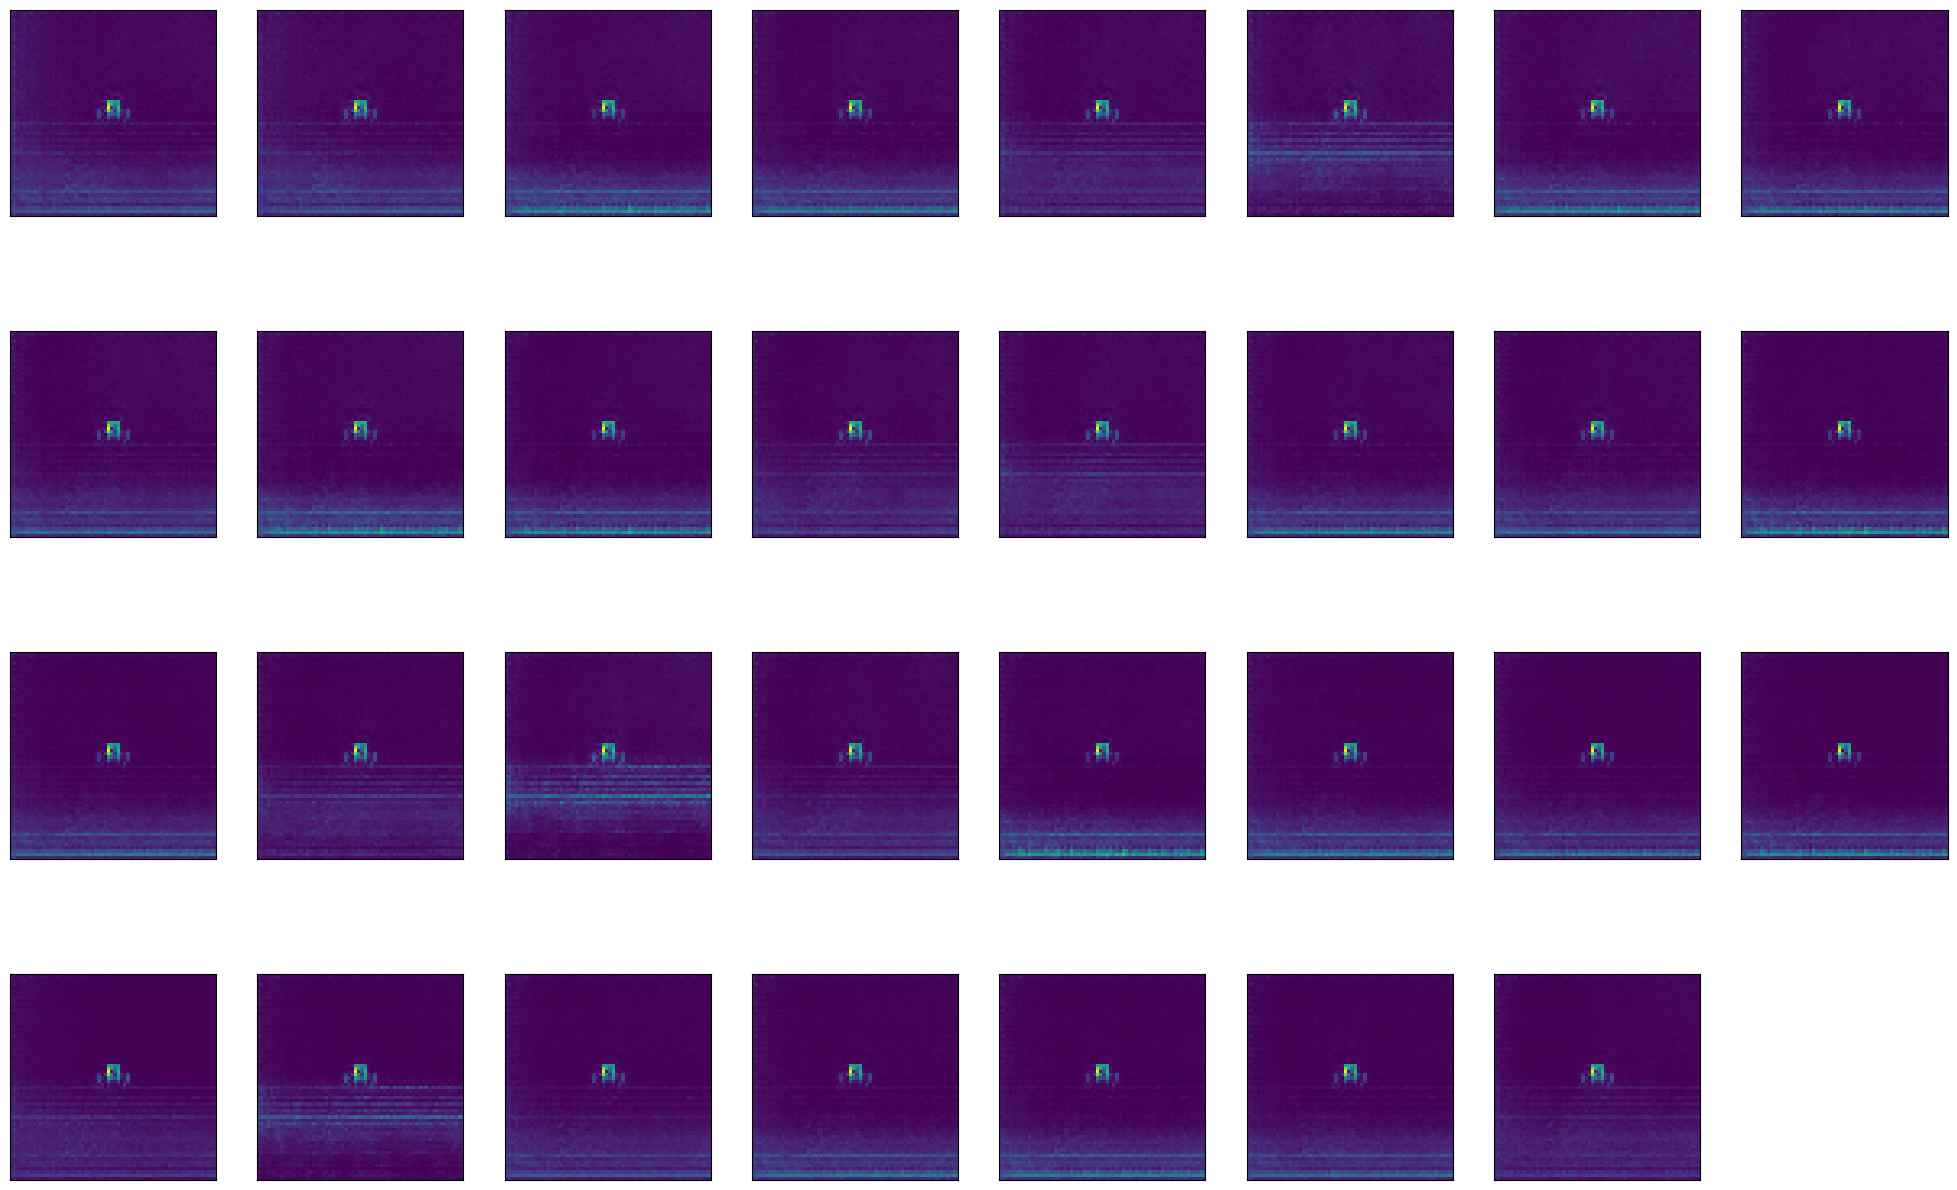

In [28]:
show_images(reconstructed_samples[15])

In [21]:
(decoder_debug(agent.posteriors_debug, agent.determenistics_debug).log_prob(pixel_normalization(torch.Tensor(sample)))/64/64).mean()

tensor(-46.9651, device='cuda:7', grad_fn=<MeanBackward0>)